In [5]:
import nltk
from nltk import FreqDist
nltk.download('stopwords')
import warnings
warnings.filterwarnings("ignore")
from nltk.corpus import stopwords
from pattern.en import tag
from nltk.corpus import wordnet as wn
from wordcloud import WordCloud
import en_core_web_sm
import pandas as pd
pd.set_option("display.max_colwidth", 200)
import numpy as np
import json
import re
import gzip
import spacy
import gensim
from gensim import corpora
import pyLDAvis
import pyLDAvis.gensim
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\praveen\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
#Unzip and extract dataset
def parse(path):
  g = gzip.open(path, 'rb')
  for l in g:
    yield eval(l)
    
def getDF(path):
  i = 0
  df = {}
  for d in parse(path):
    df[i] = d
    i += 1
  return pd.DataFrame.from_dict(df, orient='index')

In [7]:
raw_df = getDF('reviews_Clothing_Shoes_and_Jewelry_5.json.gz')
raw_df.shape

(278677, 9)

In [36]:
#Filtering to reduce local machine load
pro_filt = ['B005LERHD8','B005GYGD7O','B008WYDP1C','B0058XIMMM','B00CKGB85I','B007RD9DS8','B002RADHJC',
            'B000T9VK56','B0000C321X','B007WNWEFC','B0001ZNZJM','B007WA3K4Y','B007NLX16O','B00012O12A',
            'B0008EOEPK','B0007YR8WW','B0067GUM2W','B000O32MLI','B001IB70JY','B004Q7AB4I','B006PGGJOE',
            'B003NX87U6','B002PHLVJA','B008KK0ZJ8','B0083S18LQ','B005UVM368','B0007YVP1W','B00DNQIIE8',
            'B000KEG4V0','B004YM2FV2','B008NCYALM','B003XDVUEQ','B0007CKMA4','B008X0EW44','B00DMWQOYY',
            'B0078FXHNM','B000XDDERK','B002KMI7OC','B000J6ZYL0','B001Q5QLP6','B0074T7TY0','B00550PLV8',
            'B003DNR2HK','B007WAU1VY','B0008172S4','B00CIBCJ62','B0068VM5T4','B000FBO0DM','B000QW6LE6',
            'B000GOVRDE','B005CSNTJY','B0002TOZ1E','B004R1II48','B000DZUGOM','B00D1MR8YU','B00CN47GXA',
            'B001HEF6W0','B000PH25X8','B0013KDS96','B0000ANHST','B00DQYNS3I','B008RUOCJU','B007WAEBPQ',
            'B0053XF2U2','B0051U15E4','B001AOZVSQ','B0009F0Z38','B0026P45QW','B0007YXTOS','B0006LMBJ6',
            'B00BNB3A0W','B000EIJG0I','B000072UMJ','B000KKTPD8','B000FH4JJQ','B0076R6KY0','B0012QM8IS',
            'B0081IZ3UA','B0031U0PO2','B001188FZC','B00DMWQK0W','B004Z1CZDK','B009DNWFD0','B004M6XUI2',
            'B009ZDEXQK','B006SCSOOS','B0051D7GF8','B003DNR4XC','B002APTA9K','B0007QCOTM','B0009B3IN6',
            'B003YBHF82','B0012M0XSE','B000MXIMHI','B000KD44G8','B007DLVLAW','B0011D2FL2','B000KGOHLM',
            'B000EX15NY','B0019MPRJW']
df = raw_df[raw_df.asin.isin(pro_filt)]
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
340,A2S7YBFPZX1IGQ,B000072UMJ,alysha davis,"[0, 0]",fits true to size i can wear this with anything since it being a darker shade of purple wont stand out as much but still has that color its great just what i was looking for totally would recommen...,5.0,great shoes!,1362268800,"03 3, 2013"
341,AWF47TNS4EM6A,B000072UMJ,amazon_mama0312,"[0, 0]",I got these as a gift for my little sister. She had been wanting a pair of these for a really long time. I was so happy to find them here on amazon for the cheapest price ;) She absolutely LOVES t...,5.0,She loved them!!!,1398729600,"04 29, 2014"
342,A1UMN556PVE5ZJ,B000072UMJ,Angie,"[0, 0]",My daughter loves converse so the fact that it fit her witout us having to return or try on in the store was a plus - it arrived on time,5.0,Fit her well,1361232000,"02 19, 2013"


In [11]:
#product with negative review
pro_filt_neg = ['B00DM0587K']
df = raw_df[raw_df.asin.isin(pro_filt_neg)]
df.head(3)

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
262614,A17VF80XLCCZTN,B00DM0587K,"A. Lane ""Baking Freak""","[0, 0]","Not incredibly comfortable, but for the under $2 tag, I'm sold. You can adjust it a little because it's metal-ish. A bit heavy but hey, what do you expect?",4.0,Cheap but cute,1382313600,"10 21, 2013"
262615,AV6YZONDF9CYT,B00DM0587K,Allie_says_so,"[0, 0]",Got this as a Halloween gift for a girl who is into dragons and such. She enjoyed it. So I recommend.,5.0,Cool piece,1387497600,"12 20, 2013"
262616,A1K9AO4B6CREY,B00DM0587K,Amazon Customer,"[0, 0]","It can't support its own weight on your ear. They quality is worse than the picture portrays, but it was suuuuuuper cheap.",1.0,For Very Small Ears,1382313600,"10 21, 2013"


In [38]:
df['reviewText'].head(3)

262614    Not incredibly comfortable tag sold You adjust little metal ish bit heavy hey expect
262615                                   Got Halloween gift girl dragons She enjoyed recommend
262616                 support weight ear They quality worse picture portrays suuuuuuper cheap
Name: reviewText, dtype: object

In [6]:
df.shape

(50, 9)

In [65]:
# #Code Testing data to be hard coded

# row_data = []
# row_data.append([
#                     "This is a great tutu and at a really great price. It doesn't look cheap at all. I'm so glad I looked on Amazon and found such an affordable tutu that isn't made poorly. A++",
#                     "Great tutu-  not cheaply made"])

# row_data.append([
#                     "Great tutu for a great price. It isn't a &#34;full&#34; or high quality skirt, but it is perfect for my daughter to wear over leggings for her little outfits.",
#                     "Great value"])
# row_data.append(
#     ["My daughter liked this, and it with her costume, but she would have liked it to be a bit fuller.", 'Good'])
# row_data.append([
#                     "For what I paid for two tutus is unbeatable anywhere!  I ordered a pink and turquios and they are vibrant and beautiful! The tutu is very full! Princess style! Not cheaply made! Not cheap materia! Obviously someone made these with love and care! I paid less than 7 bucks for a tutu I and I feel proud of my self for researching to the point of finding gold!Recommend 2-6 years!My daughter is two ! Wears size 4t and this skirt ( one size ) fit perfect and will probaly be able to accommodate her quickly growing waist for some time!",
#                     "WOW !! ..is al345l I have to say!"])
# row_data.append([
#                     "Wonder my niece wears it every single day, yellow is her favorite color right now an this cute little tutu made he da. It is well built and we hope she gets lots of wear out of it.",
#                     "Wonderful and great shipping."])
# row_data.append([
#                     "My daughter has worn this skirt almost every day since she received it and it's even been through the washer along with the other clothes.  It's amazing quality!  She fits a 4T and it's just above her knee, and has a little bit of growing room, although I'm not so sure as much as others are saying.  But considering how often she wears it, I'm not worried! ;)",
#                     'Excellent quality!'])

# df = pd.DataFrame(row_data, columns=['reviewText','summary'])

# # #preview dataframe
# # headers = review_df.dtypes.index
# # print(headers)
# # sample = review_df.head()
# # print(sample)

In [66]:
# df.head()

In [12]:
#Word Frequency bar chart
def freq_words(x, terms = 30):
  all_words = ' '.join([text for text in x])
  all_words = all_words.split()
  
  fdist = FreqDist(all_words)
  words_df = pd.DataFrame({'word':list(fdist.keys()), 'count':list(fdist.values())})
  
  # selecting top 20 most frequent words
  d = words_df.nlargest(columns="count", n = terms) 
  plt.figure(figsize=(20,5))
  ax = sns.barplot(data=d, x= "word", y = "count")
  ax.set(ylabel = 'Count')
  plt.show()

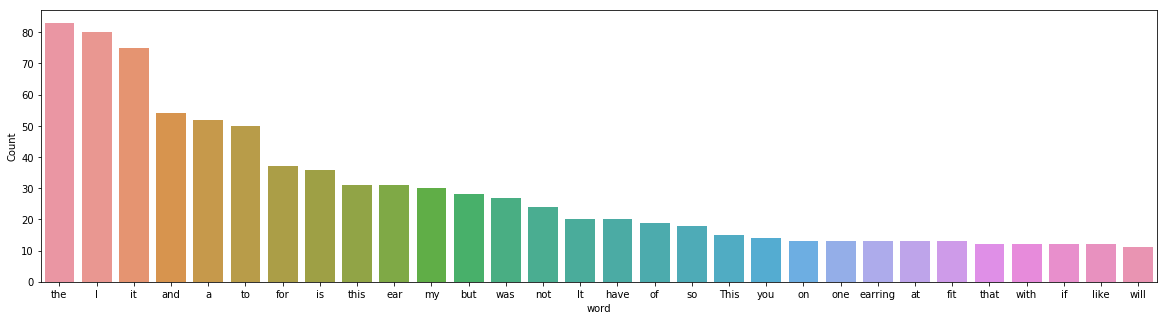

In [8]:
freq_words(df['reviewText'])

In [13]:
# replace "n't" with " not"
df['reviewText'] = df['reviewText'].str.replace("n\'t", " not")

# remove unwanted characters, numbers and symbols
df['reviewText'] = df['reviewText'].str.replace("[^a-zA-Z#]", " ")

#number of stop words
stop = stopwords.words('english')
custom_stop = ['the','they','this']
for x in custom_stop:
    stop.append(x)
df['review_stopwords'] = df['reviewText'].apply(lambda x: len([x for x in x.split() if x in stop]))
df['summary_stopwords'] = df['summary'].apply(lambda x: len([x for x in x.split() if x in stop]))
print(df[['review_stopwords','summary_stopwords']].head(5))

#remove Stop words
df['reviewText'] = df['reviewText'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['summary'] = df['summary'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

# remove short words (length < 3)
df['reviewText'] = df['reviewText'].apply(lambda x: ' '.join([w for w in x.split() if len(w)>2]))

#convert all char to lower case
reviews = df['reviewText'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['summary'] = df['summary'].apply(lambda x: " ".join(x.lower() for x in x.split()))


        review_stopwords  summary_stopwords
262614                15                  1
262615                11                  0
262616                11                  0
262617                10                  1
262618                20                  0


In [ ]:
#print reviews after text cleaning
df['clean_review'] = reviews

In [37]:
df[['reviewText', 'clean_review']].head(10)

,reviewText,clean_review
262614,Not incredibly comfortable tag sold You adjust little metal ish bit heavy hey expect,not incredibly comfortable tag sold you adjust little metal ish bit heavy hey expect
262615,Got Halloween gift girl dragons She enjoyed recommend,got halloween gift girl dragons she enjoyed recommend
262616,support weight ear They quality worse picture portrays suuuuuuper cheap,support weight ear they quality worse picture portrays suuuuuuper cheap
262617,This poorly made fell apart daughter even able wear one time She really disappointed,this poorly made fell apart daughter even able wear one time she really disappointed
262618,This dragon earring fits better others since actually put tail bottom earring hole would recommend one instead others hooks top ear latches bottom earring hole,this dragon earring fits better others since actually put tail bottom earring hole would recommend one instead others hooks top ear latches bottom earring hole
262619,This best earring ever owned lost back threw away,this best earring ever owned lost back threw away
262620,Arrived earring stud bent remove add chain Good price refined piece,arrived earring stud bent remove add chain good price refined piece
262621,cheap heavy care sits ear suggest buying better item one winner,cheap heavy care sits ear suggest buying better item one winner
262622,big moms ear bought took long ship got piercing could use well,big moms ear bought took long ship got piercing could use well
262623,Does fit ear ever seen There way could looks cool would fit,does fit ear ever seen there way could looks cool would fit


In [33]:
print(stop)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

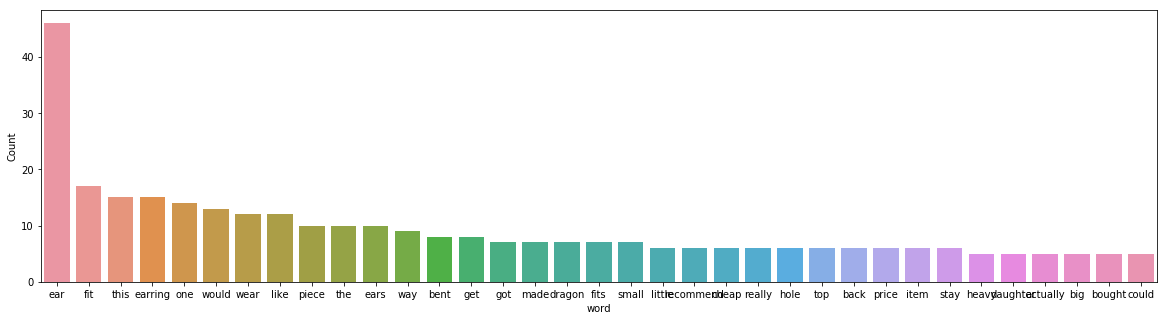

In [10]:
freq_words(reviews, 35)

In [14]:
nlp = en_core_web_sm.load(disable=['parser', 'ner'])

#lemmatization method
def lemmatization(texts, tags=['NOUN', 'ADJ', 'VERB']):
    output = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        output.append([token.lemma_ for token in doc if token.pos_ in tags])
    return output

#tokenization
tokenized_reviews = pd.Series(reviews).apply(lambda x: x.split())

In [41]:
print(tokenized_reviews.iloc[[3]])

262617    [this, poorly, made, fell, apart, daughter, even, able, wear, one, time, she, really, disappointed]
Name: reviewText, dtype: object


In [15]:
#lemmatization takes a lot of time to load
reviews_2 = lemmatization(tokenized_reviews)

In [16]:
print(reviews_2[3])

['make', 'fall', 'daughter', 'able', 'wear', 'time', 'disappoint']


In [ ]:
#Creating bi-gram



In [18]:
# Merge processed reviews with df in a seperate column
reviews_3 = []
for i in range(len(reviews_2)):
    reviews_3.append(' '.join(reviews_2[i]))
    
df['reviews'] = reviews_3

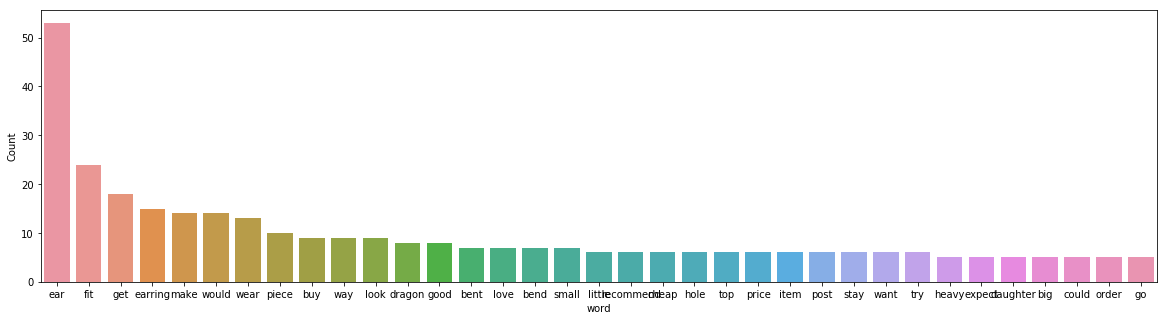

In [14]:
freq_words(df['reviews'], 35)

In [20]:
# Create the term dictionary of our corpus, where every unique term is assigned an index
dictionary = corpora.Dictionary(reviews_2)

# Convert list of reviews (reviews_2) into a Document Term Matrix using the dictionary prepared above.
doc_term_matrix = [dictionary.doc2bow(rev) for rev in reviews_2]

In [21]:
# Creating the object for LDA model using gensim library
LDA = gensim.models.ldamodel.LdaModel

# Build LDA model
warnings.filterwarnings("ignore", category=DeprecationWarning)
lda_model = LDA(corpus=doc_term_matrix,
                id2word=dictionary,
                num_topics=20, 
                random_state=30,
                chunksize=1000,
                passes=1)
#Print topics
lda_model.print_topics(num_topics=5,num_words=5)

[(9,
  '0.022*"ear" + 0.017*"fit" + 0.014*"way" + 0.013*"dollar" + 0.010*"small"'),
 (6,
  '0.033*"piece" + 0.031*"ear" + 0.026*"friend" + 0.026*"bend" + 0.020*"wear"'),
 (11,
  '0.065*"gift" + 0.033*"undamaged" + 0.033*"would" + 0.033*"product" + 0.033*"sister"'),
 (12,
  '0.078*"wear" + 0.030*"fall" + 0.030*"time" + 0.024*"hard" + 0.024*"cheap"'),
 (0,
  '0.032*"make" + 0.032*"enjoy" + 0.032*"gift" + 0.032*"daughter" + 0.032*"get"')]

In [23]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, doc_term_matrix, dictionary)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
4     -0.148345 -0.020210       1        1  16.671852
5     -0.103465  0.048240       2        1  12.346841
13     0.049633 -0.138720       3        1   9.649647
2      0.023049 -0.125790       4        1   9.039009
1     -0.090129  0.025109       5        1   8.625083
18    -0.158401 -0.064814       6        1   5.891310
6      0.058896 -0.040650       7        1   5.689091
17    -0.054701  0.060600       8        1   4.901820
8      0.030164 -0.025663       9        1   4.429568
7      0.050772  0.154382      10        1   3.723935
16    -0.001518  0.059388      11        1   3.501622
14     0.055182 -0.005441      12        1   3.409923
3      0.097314 -0.002932      13        1   2.918871
19     0.019474 -0.067533      14        1   2.528057
0      0.050929  0.020717      15        1   1.723606
11     0.066745  0.037704      16        1   1.702473
12     0.002887  0.068261      17        1   1.349749
10    -0.002806  0.011069      18        1   1.349748
15     0.049737  0.014252      19        1   0.273901
9      0.004584 -0.007970      20        1   0.273901, topic_info=     Category       Freq       Term      Total  loglift  logprob
term                                                            
35    Default  18.000000        fit  18.000000  30.0000  30.0000
19    Default  41.000000        ear  41.000000  29.0000  29.0000
34    Default  11.000000    earring  11.000000  28.0000  28.0000
32    Default   9.000000       wear   9.000000  27.0000  27.0000
12    Default  13.000000        get  13.000000  26.0000  26.0000
44    Default  10.000000      would  10.000000  25.0000  25.0000
36    Default   6.000000       good   6.000000  24.0000  24.0000
59    Default   5.000000       item   5.000000  23.0000  23.0000
37    Default   4.000000       hole   4.000000  22.0000  22.0000
80    Default   5.000000       love   5.000000  21.0000  21.0000
30    Default  10.000000       make  10.000000  20.0000  20.0000
10    Default   6.000000     dragon   6.000000  19.0000  19.0000
13    Default   2.000000       gift   2.000000  18.0000  18.0000
53    Default   5.000000      price   5.000000  17.0000  17.0000
16    Default   4.000000  recommend   4.000000  16.0000  16.0000
3     Default   4.000000     expect   4.000000  15.0000  15.0000
4     Default   4.000000      heavy   4.000000  14.0000  14.0000
150   Default   4.000000       want   4.000000  13.0000  13.0000
75    Default   7.000000        way   7.000000  12.0000  12.0000
18    Default   4.000000      cheap   4.000000  11.0000  11.0000
33    Default   2.000000     bottom   2.000000  10.0000  10.0000
57    Default   6.000000        buy   6.000000   9.0000   9.0000
52    Default   8.000000      piece   8.000000   8.0000   8.0000
31    Default   2.000000       time   2.000000   7.0000   7.0000
85    Default   5.000000       bend   5.000000   6.0000   6.0000
29    Default   2.000000       fall   2.000000   5.0000   5.0000
208   Default   3.000000       come   3.000000   4.0000   4.0000
173   Default   3.000000    product   3.000000   3.0000   3.0000
69    Default   3.000000       take   3.000000   2.0000   2.0000
27    Default   3.000000   daughter   3.000000   1.0000   1.0000
...       ...        ...        ...        ...      ...      ...
107   Topic20   0.012837    because   1.342774   1.2500  -5.1946
309   Topic20   0.012305    breaker   1.326299   1.2200  -5.2370
123   Topic20   0.016291       send   1.768233   1.2131  -4.9563
125   Topic20   0.018873     silver   2.096962   1.1896  -4.8092
315   Topic20   0.011971       stem   1.337987   1.1837  -5.2644
312   Topic20   0.017898  packaging   2.047643   1.1604  -4.8623
20    Topic20   0.016478    picture   1.920761   1.1417  -4.9449
308   Topic20   0.011250     accept   1.338739   1.1210  -5.3266
128   Topic20   0.017508      waste   2.091681   1.1171  -4.8843
313   Topic20   0.016278       poor   2

## Compute Model Perplexity and Coherence Score

In [32]:
from gensim.models import CoherenceModel
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(doc_term_matrix))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=reviews_2, dictionary=dictionary, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -6.951938113587848

Coherence Score:  0.4136262712912234


## Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    

In [19]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [20]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=dictionary, corpus=doc_term_matrix, texts=reviews_2, start=2, limit=40, step=6)

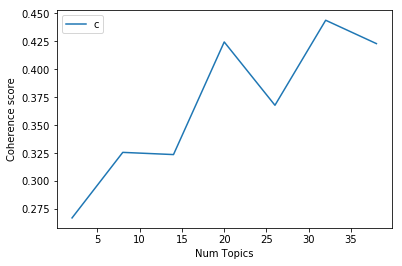

In [21]:
# Show graph
limit=40; start=2; step=6;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [22]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2672
Num Topics = 8  has Coherence Value of 0.3257
Num Topics = 14  has Coherence Value of 0.3237
Num Topics = 20  has Coherence Value of 0.4243
Num Topics = 26  has Coherence Value of 0.3678
Num Topics = 32  has Coherence Value of 0.4437
Num Topics = 38  has Coherence Value of 0.4228


In [23]:
print(model_list[5])


LdaModel(num_terms=375, num_topics=32, decay=0.5, chunksize=2000)


In [25]:
# Select the model and print the topics
import pprint
optimal_model = model_list[5]
model_topics = optimal_model.show_topics(formatted=False)

## '''Finding the dominant topic in each sentence'''

In [26]:
def format_topics_sentences(ldamodel=lda_model, corpus=doc_term_matrix, texts=reviews_2):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=optimal_model, corpus=doc_term_matrix,texts=reviews_2)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']

# Show
df_dominant_topic.head(10)

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.9119,"ear, dragon, piece, get, bar, body, rat, size, hole, say","[comfortable, tag, sell, adjust, little, metal, ish, bit, heavy, expect]"
1,1,0.0,0.8789,"be, enjoy, sis, go, recommend, make, girl, halloween, get, christma","[get, halloween, gift, girl, dragon, enjoy, recommend]"
2,2,14.0,0.9031,"wear, ear, price, cheap, bad, expect, nice, able, thank, time","[support, weight, ear, quality, bad, picture, portray, suuuuuuper, cheap]"
3,3,12.0,0.8789,"make, earring, fit, wear, item, punk, gift, own, able, time","[make, fall, daughter, able, wear, time, disappoint]"
4,4,9.0,0.9539,"ear, earring, good, wear, hole, fit, other, bottom, item, get","[dragon, earring, fit, good, other, put, tail, bottom, earring, hole, would, recommend, other, hook, top, ear, latch, bottom, earring, hole]"
5,5,12.0,0.8385,"make, earring, fit, wear, item, punk, gift, own, able, time","[good, earring, own, lose, throw]"
6,6,9.0,0.9193,"ear, earring, good, wear, hole, fit, other, bottom, item, get","[arrive, earring, stud, bent, remove, add, chain, good, price, refined, piece]"
7,7,9.0,0.9031,"ear, earring, good, wear, hole, fit, other, bottom, item, get","[cheap, heavy, care, sit, suggest, buy, good, item, winner]"
8,8,22.0,0.9193,"big, ear, use, could, piercing, ship, take, mom, long, get","[big, mom, ear, buy, take, long, ship, get, piercing, could, use]"
9,9,13.0,0.9119,"fit, ear, back, bend, could, post, earring, make, come, bent","[do, fit, ear, see, way, could, look, cool, would, fit]"


## Find the most representative document for each topic

In [27]:
# Group top 5 sentences under each topic
sent_topics_sorteddf_mallet = pd.DataFrame()

sent_topics_outdf_grpd = df_topic_sents_keywords.groupby('Dominant_Topic')

for i, grp in sent_topics_outdf_grpd:
    sent_topics_sorteddf_mallet = pd.concat([sent_topics_sorteddf_mallet, 
                                             grp.sort_values(['Perc_Contribution'], ascending=[0]).head(1)], 
                                            axis=0)

# Reset Index    
sent_topics_sorteddf_mallet.reset_index(drop=True, inplace=True)

# Format
sent_topics_sorteddf_mallet.columns = ['Topic_Num', "Topic_Perc_Contrib", "Keywords", "Text"]

# Show
sent_topics_sorteddf_mallet.head()

,Topic_Num,Topic_Perc_Contrib,Keywords,Text
0,0.0,0.9193,"be, enjoy, sis, go, recommend, make, girl, halloween, get, christma","[make, door, be, part, christma, goth, basket, sis, know, go, order]"
1,1.0,0.9354,"ear, want, fit, matching, perfect, stud, ring, fill, requirement, get","[ear, ring, beautiful, correct, ear, stud, requirement, want, fit, top, ear, fill, outer, ear]"
2,3.0,0.9462,"ear, buy, fan, daughter, pierce, make, care, big, fit, pin","[lay, little, awkward, ear, ear, weight, popular, hunger, game, fan, daughter, buy, item, fan, mean, care, fit]"
3,5.0,0.9031,"sorry, yrs, ear, beautiful, change, need, fit, large, small, afraid","[beautiful, large, small, ear, yrs, need, change, fit, sorry]"
4,6.0,0.9833,"ear, dragon, piece, get, bar, body, rat, size, hole, say","[could, give, less, star, would, arrive, bent, belief, third, time, try, review, product, hope, get, post, waste, money, photo, nice, look, dragon, receipt, tear, package, open, find, hope, crush,..."
